In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Testing User Recommendation matrix

In this step dataset preprocessed in previous step is loaded and simple baseline model is tested.

Each line in a dataset contains data about one user and his final action on the offer. 
Either offer has been ignored, viewed or completed (offer proved to be interesting to a customer).

In [135]:
df = pd.read_csv('./userdata.csv')

In [136]:
df.head()

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,118,20170212,0,68be06ca386d4c31939f3a4f0e3dd783,0,1162,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
1,68,20180426,2,e2127556f4f64592b11af22de27a7932,4,724,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
2,118,20170925,0,8ec6ce2a7e7949b1bf142def7d0e0586,0,937,1.0,462.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
3,118,20171002,0,68617ca6246f4fbc85e91a2a49552598,0,930,1.0,432.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
4,65,20180209,2,389bc3fa690240e798340f5a15918d5c,3,800,2.0,498.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0


In [137]:
print("Dataset contains %s actions:", len(df))

72628

### Let's plot the actions for one user

From the output can be seen that user completed an offer `0b1e...` and viewed `ae26...`. Offer `2906..` had been ignored twice.

In [138]:

df[df.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
5,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
6,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
7146,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,2.0,456.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0
50876,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0


In [ ]:
### Preparing data for training
Let's create user-offer matrix by encoding each id into categorical value.

In [139]:
def to_categorical(df, columns):
    for col in columns:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes
    return df

In [140]:
df.dtypes

age                   int64
became_member_on      int64
gender                int64
id                   object
income                int64
memberdays            int64
event               float64
time                float64
offer_id             object
difficulty            int64
duration              int64
reward                int64
web                   int64
email                 int64
mobile                int64
social                int64
bogo                  int64
discount              int64
informational         int64
dtype: object

Recommendation matrix is very similar to embeddings. So we will leverage this and will train embedding along the model.

In [142]:
# Set embedding sizes
N = len(df['id'].unique())
M = len(df['offer_id'].unique())

# Set embedding dimension
D = 100

In [143]:
# Create a neural network
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, output_dim, layers=[1024], p=0.4):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        
        layerlist = []
        n_in = 2 * self.D
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],output_dim))
        self.layers = nn.Sequential(*layerlist)
        
        nn.init.xavier_uniform_(self.layers[0].weight)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.xavier_uniform_(self.layers[-1].weight)
        nn.init.zeros_(self.layers[-1].bias)

    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)

        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)

        x = self.layers(out)
        return x

In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Model(N, M, D, output_dim=df['event'].nunique(), layers=[512, 256])
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

cpu


In [145]:
# offer_specs = ['offer_id', 'difficulty', 'duration', 'reward', 'web',
#        'email', 'mobile', 'social', 'bogo', 'discount', 'informational']
# user_specs = ['age', 'became_member_on', 'gender', 'id', 'income', 'memberdays']

In [146]:
# Convert to tensors

# We name events as rating for give better insight on the target value
# and ease of comparison to other similar models

user_ids_t = torch.from_numpy(df['id'].values).long()
offer_ids_t = torch.from_numpy(df['offer_id'].values).long()
ratings_t = torch.from_numpy(df['event'].values).long()

In [147]:
# Make datasets

N_train = int(0.8 * len(df['event'].values))
N_test = 1000
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:N_train],
    offer_ids_t[:N_train],
    ratings_t[:N_train],
)

val_dataset = torch.utils.data.TensorDataset(
    user_ids_t[N_train:-N_test],
    offer_ids_t[N_train:-N_test],
    ratings_t[N_train:-N_test],
)
test_df = df[-N_test:]

In [148]:
# Data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [149]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    acc_list = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for users, offer, targets in train_loader:
            

            # move data to GPU
            users, offer, targets = users.to(device), offer.to(device), targets.to(device)
            #targets = targets.view(-1, 1).long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(users, offer)
            
            loss = criterion(outputs, targets.squeeze())

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
            # Track the accuracy
            total = targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / total
            acc_list.append(acc)

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        val_loss = []
        
        # validation
        with torch.no_grad():
            model.eval()
            
            for users, offer, targets in validation_loader:
                users, offer, targets = users.to(device), offer.to(device), targets.to(device)
                #targets = targets.view(-1, 1).long()
                outputs = model(users, offer)
                loss = criterion(outputs, targets.squeeze())
                val_loss.append(loss.item())
        
        val_loss = np.mean(val_loss)
        # Save losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Validation Loss: {train_loss:.4f}, '
              f'Test Loss: {val_loss:.4f}, Accuracy: {acc}, Duration: {dt}')

    return train_losses, val_losses

Epoch 1/25, Validation Loss: 0.8510, Test Loss: 0.9514, Accuracy: 0.7727272727272727, Duration: 0:01:18.158801
Epoch 2/25, Validation Loss: 0.7547, Test Loss: 0.8852, Accuracy: 0.6818181818181818, Duration: 0:01:11.026474
Epoch 3/25, Validation Loss: 0.6906, Test Loss: 0.9147, Accuracy: 0.8181818181818182, Duration: 0:03:51.211713
Epoch 4/25, Validation Loss: 0.5644, Test Loss: 1.0350, Accuracy: 0.7727272727272727, Duration: 0:05:09.712977
Epoch 5/25, Validation Loss: 0.4376, Test Loss: 1.2486, Accuracy: 1.0, Duration: 0:06:00.262654
Epoch 6/25, Validation Loss: 0.3318, Test Loss: 1.7086, Accuracy: 0.9545454545454546, Duration: 0:06:40.462611
Epoch 7/25, Validation Loss: 0.2388, Test Loss: 2.2818, Accuracy: 0.8636363636363636, Duration: 0:06:52.895919
Epoch 8/25, Validation Loss: 0.1582, Test Loss: 3.5720, Accuracy: 0.8636363636363636, Duration: 0:05:14.892335
Epoch 9/25, Validation Loss: 0.0994, Test Loss: 5.1534, Accuracy: 1.0, Duration: 0:05:14.172088
Epoch 10/25, Validation Loss: 0

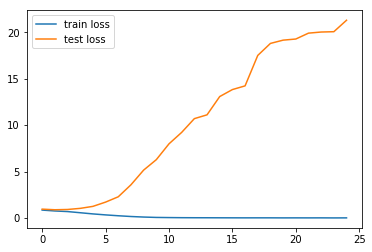

In [150]:
train_losses, val_losses = batch_gd( \
    model, criterion, optimizer, train_loader, validation_loader, 25)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='test loss')
plt.legend()
plt.show()

In [151]:
start_ix = 10
end_ix = 20
test_X =  torch.from_numpy(test_df.iloc[start_ix:end_ix]['id'].values).long()
test_y = torch.from_numpy(test_df.iloc[start_ix:end_ix]['event'].values).long()

with torch.no_grad():
    
    model.eval()
    pred = model(test_X, test_y)
    print(pred)
_, predicted = torch.max(pred.data, 1)
print(predicted)

tensor([[-2.7465e-02, -9.6336e+00,  9.6108e+00],
        [-7.5339e+01, -5.1662e+00,  5.6592e+01],
        [-7.5339e+01, -5.1662e+00,  5.6592e+01],
        [ 5.3495e+00, -4.3944e+00, -3.8782e-02],
        [-7.2802e+00, -1.3971e+01,  2.0986e+01],
        [ 3.6589e+00, -1.5677e+01, -3.8250e+00],
        [ 6.7292e+00, -1.2269e+00, -5.9331e+00],
        [ 2.0217e+00, -1.7158e+01,  1.3448e+01],
        [-3.7386e+01,  1.7088e+01, -1.2827e+00],
        [-1.2210e+01,  6.0459e+00,  4.6745e+00]])
tensor([2, 2, 2, 0, 2, 0, 0, 2, 1, 1])


In [152]:
from sklearn.metrics import confusion_matrix,  accuracy_score
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Plot confusion matrix and baseline accuracy

Confusion matrix, without normalization
[[0 0 0]
 [1 2 2]
 [2 0 3]]


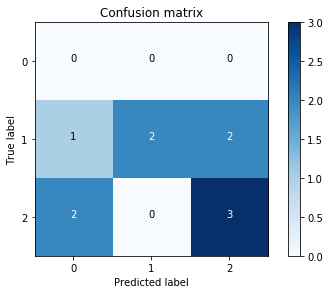

In [153]:
cm = confusion_matrix(test_y, predicted)
classes = [0,1,2]
plot_confusion_matrix(cm, classes)

In [154]:
print("Accuracy so far: " + str(100*accuracy_score(test_y, predicted))+ "%" )

Accuracy so far: 50.0%


Results are decent so far and almost twice better than random quessing.

#### Show some misclassified examples

In [156]:
data = test_df.iloc[start_ix:end_ix][['age', 'became_member_on', 'gender', 'id', 'income', 'memberdays', 'event']]#['offer_id'].values
pred_values = pd.DataFrame(predicted, columns=['predicted'], index=data.index)
pd.concat([data, pred_values], axis=1)

,age,became_member_on,gender,id,income,memberdays,event,predicted
71638,42,20170806,2,11854,4,987,2.0,2
71639,118,20150829,0,6712,0,1695,1.0,2
71640,118,20150829,0,6712,0,1695,1.0,2
71641,47,20180427,3,5350,3,723,1.0,0
71642,70,20160325,3,6908,3,1486,2.0,2
71643,59,20160815,2,14044,6,1343,2.0,0
71644,49,20171110,2,11158,5,891,2.0,0
71645,73,20170626,2,3378,2,1028,2.0,2
71646,41,20161212,2,11261,1,1224,1.0,1
71647,49,20170428,2,9752,4,1087,1.0,1


Now let's save the model for future reference

In [162]:
#!mkdir model
import os

def save_model(model, model_name, model_info):
    # Save the parameters used to construct the model
    with open(model_name, 'wb') as f:
        torch.save(model_info, f)

    # Save the model parameters
    
    with open(model_name, 'wb') as f:
        torch.save(model.cpu().state_dict(), f)

model_info = {
         'n_users': M, 
          'n_items': N, 
          'embed_dim': D, 
          'output_dim': df['event'].nunique(), 
          'layers': [512, 256], 
          'p': 0.4
    }
save_model(model, './model/BaselineModel.pth', model_info)

During the next step we improve the model to take additional paramenters that describe each user and each offer, which should hopefully, give the model insigths on why a particular customer may like or not like given offer.